# Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import gymnasium as gym
from gymnasium import spaces
import datetime
import my_library as mylib
# import importlib
# importlib.reload(my_library)
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pickle
pd.options.mode.chained_assignment = None

# Data manipulation

In [2]:
tickers = ['PFE','OXY','JPM','MCD'] # Pfizer, Occidental Petroleum, JPMorgan Chase, McDonald's
# tickers1 = ['PFE ','OXY ','JPM ','MCD '] 
tickers_vol = [ticker+'_VOL' for ticker in tickers]
data = pd.read_csv('others.csv', sep=',')
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')
adj_close = data[tickers[3]]
df = pd.DataFrame({'Date': data['Date'], 'log_ret': np.log(adj_close/adj_close.shift(1)).dropna(), tickers_vol[3]: data[tickers_vol[3]]}).dropna().set_index('Date')
sp500 = pd.read_csv('sp500_joined_closes (3).csv', sep=',').dropna(axis=1)
data.set_index('Date', inplace=True)
new_cols = list([])
for i, col in enumerate(sp500.columns):
    if col.endswith(' '):
        new_cols.append(col[:-1])
    elif col.endswith(' _VOL'):
        new_cols.append(col[:-5]+'_VOL')
    else:
        new_cols.append(col)
sp500.columns = new_cols
sp500.drop(tickers[3], axis=1, inplace=True)
sp500.drop(tickers_vol[3], axis=1, inplace=True)
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500 = sp500.set_index('Date')
col_stocks = [col for col in sp500.columns if not col.endswith('VOL')]
col_vols = [col for col in sp500.columns if col.endswith('VOL')]
any(col == 'Date' for col in col_stocks)

False

In [3]:
sp500_lr = np.log(sp500[col_stocks]/sp500[col_stocks].shift(1))
sp500_lr = sp500_lr.drop(sp500_lr.index[0])
sp500_lr = sp500_lr.drop([col for col in sp500_lr.columns if sp500_lr[col].count() < 3633], axis=1)
df = df.join(sp500[col_vols],how='inner').dropna()
df = df.join(sp500_lr,how='inner').dropna()
df.describe()

log_ret       MCD_VOL       MMM_VOL       AOS_VOL       ABT_VOL  \
count  3638.000000  3.638000e+03  3.638000e+03  3.638000e+03  3.638000e+03   
mean      0.000491  4.590596e+06  3.672072e+06  1.363582e+06  8.361895e+06   
std       0.011698  2.527914e+06  2.911937e+06  1.103023e+06  5.976096e+06   
min      -0.172871  9.632000e+05  7.785960e+05  2.042000e+05  1.067700e+06   
25%      -0.004830  2.860250e+06  2.380937e+06  8.305000e+05  4.614210e+06   
50%       0.000729  4.000050e+06  3.098058e+06  1.113950e+06  6.282250e+06   
75%       0.005928  5.615875e+06  4.108499e+06  1.586875e+06  1.024750e+07   
max       0.166577  3.647160e+07  6.043675e+07  3.248830e+07  7.810838e+07   

            ACN_VOL      ADBE_VOL       AMD_VOL       AES_VOL       AFL_VOL  \
count  3.638000e+03  3.638000e+03  3.638000e+03  3.638000e+03  3.638000e+03   
mean   2.772958e+06  3.756350e+06  4.659924e+07  5.907124e+06  4.438843e+06   
std    2.315021e+06  3.470823e+06  3.549588e+07  2.840392e+06  2.835895e+06   
min    5.281000e+05  5.892000e+05  0.000000e+00  9.862000e+05  8.789000e+05   
25%    1.813925e+06  2.136200e+06  1.889980e+07  4.110050e+06  2.677625e+06   
50%    2.333400e+06  2.906300e+06  3.877410e+07  5.336600e+06  3.640550e+06   
75%    3.150400e+06  4.277000e+06  6.321760e+07  7.026075e+06  5.307400e+06   
max    8.965590e+07  1.087524e+08  3.250584e+08  4.606760e+07  3.669320e+07   

       ...          WST          WDC           WY          WMB          WTW  \
count  ...  3638.000000  3638.000000  3638.000000  3638.000000  3638.000000   
mean   ...     0.000799     0.000218     0.000296     0.000441     0.000433   
std    ...     0.017123     0.027057     0.019391     0.024196     0.014200   
min    ...    -0.151802    -0.228719    -0.257132    -0.427912    -0.113525   
25%    ...    -0.007562    -0.013190    -0.009073    -0.009434    -0.005715   
50%    ...     0.000930     0.000462     0.000681     0.000740     0.000695   
75%    ...     0.009358     0.014244     0.009957     0.010422     0.007123   
max    ...     0.135745     0.190144     0.225664     0.295550     0.140681   

              WYNN          XEL          YUM         ZBRA          ZBH  
count  3638.000000  3638.000000  3638.000000  3638.000000  3638.000000  
mean      0.000211     0.000391     0.000539     0.000641     0.000194  
std       0.028792     0.012314     0.015034     0.022864     0.016214  
min      -0.280172    -0.135726    -0.208654    -0.272411    -0.150757  
25%      -0.013317    -0.005615    -0.006247    -0.009777    -0.007351  
50%      -0.000104     0.000632     0.000839     0.000930     0.000163  
75%       0.013625     0.007141     0.007597     0.011237     0.008326  
max       0.244422     0.106679     0.209032     0.158833     0.144790  

[8 rows x 860 columns]

Performing PCA on AAPL and SP500 stocks

In [4]:
cum_var_exp, PCs, regr_PCs, eig_vecs = mylib.PCA(df['log_ret'], sp500_lr, plot=False)

In [5]:
regr_PCs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   AAPL   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     340.3
Date:                Sun, 08 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:17:32   Log-Likelihood:                 12225.
No. Observations:                3638   AIC:                        -2.443e+04
Df Residuals:                    3627   BIC:                        -2.436e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.714e-05      0.000     -0.336      0.737      -0.000       0.000
PC0            0.0382      0.001     51.291      0.000       0.037       0.040
PC1           -0.0313      0.002    -14.993      0.000      -0.035      -0.027
PC2         6.105e-05      0.002      0.032      0.975      -0.004       0.004
PC3           -0.0017      0.003     -0.589      0.556      -0.007       0.004
PC4           -0.0159      0.003     -5.744      0.000      -0.021      -0.010
PC5            0.0201      0.003      5.792      0.000       0.013       0.027
PC6            0.0394      0.004     10.548      0.000       0.032       0.047
PC7           -0.0336      0.004     -9.070      0.000      -0.041      -0.026
PC8           -0.0486      0.004    -11.497      0.000      -0.057      -0.040
PC9            0.0427      0.004      9.959      0.000       0.034       0.051
==============================================================================
Omnibus:                      708.543   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11320.750
Skew:                           0.465   Prob(JB):                         0.00
Kurtosis:                      11.592   Cond. No.                         33.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
PCs.columns = PCs.columns.str.replace('AAPL', tickers[3])

In [7]:
Y = PCs[tickers[3]]

In [8]:
[i-1 for i,p in enumerate(regr_PCs.tvalues) if abs(p) > 1.96]

[0, 1, 4, 5, 6, 7, 8, 9]

In [9]:
t_vals = regr_PCs.tvalues.drop('const')

In [10]:
t_vals.drop([p for p in t_vals.index if abs(t_vals[p]) == abs(t_vals).min()], inplace=True)
list(t_vals.index)

['PC0', 'PC1', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9']

In [11]:
X = PCs[list(t_vals.index)]
X

PC0       PC1       PC3       PC4       PC5       PC6  \
Date                                                                     
2010-01-05  0.078088  0.106214 -0.037447 -0.054191  0.000469  0.027937   
2010-01-06  0.046041  0.025009  0.020452  0.052009 -0.019373  0.025302   
2010-01-07  0.118599  0.057949 -0.033883 -0.133885  0.015994  0.017216   
2010-01-08  0.056626  0.054211  0.026393  0.064161 -0.061388 -0.022671   
2010-01-11  0.058542 -0.042092 -0.005828  0.000504  0.002869 -0.004254   
...              ...       ...       ...       ...       ...       ...   
2024-06-12  0.113942  0.110459 -0.103836 -0.033703 -0.048290 -0.080403   
2024-06-13 -0.053007 -0.051436 -0.027852 -0.036106 -0.002849  0.011652   
2024-06-14 -0.127297 -0.086229 -0.001384 -0.008780  0.061025 -0.016138   
2024-06-17  0.147163  0.081944  0.034263 -0.054220 -0.053641  0.040649   
2024-06-18  0.058817  0.020314  0.022345  0.010475 -0.007144 -0.052934   

                 PC7       PC8       PC9  
Date                                      
2010-01-05 -0.025402  0.067193 -0.009016  
2010-01-06  0.058590 -0.045648  0.014718  
2010-01-07  0.048260 -0.027126 -0.016291  
2010-01-08 -0.001498 -0.041022 -0.012875  
2010-01-11  0.011157 -0.011794 -0.061494  
...              ...       ...       ...  
2024-06-12  0.022717 -0.002245 -0.014825  
2024-06-13 -0.005665  0.001139  0.014918  
2024-06-14 -0.006261  0.012192  0.071275  
2024-06-17 -0.070650 -0.028771  0.057907  
2024-06-18 -0.021137  0.028158  0.010794  

[3638 rows x 9 columns]

In [12]:
regr_PCs = sm.OLS(Y, X).fit()
regr_PCs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    MCD   R-squared (uncentered):                   0.485
Model:                            OLS   Adj. R-squared (uncentered):              0.484
Method:                 Least Squares   F-statistic:                              379.7
Date:                Sun, 08 Sep 2024   Prob (F-statistic):                        0.00
Time:                        20:17:49   Log-Likelihood:                          12225.
No. Observations:                3638   AIC:                                 -2.443e+04
Df Residuals:                    3629   BIC:                                 -2.438e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PC0            0.0382      0.001     51.393      0.000       0.037       0.040
PC1           -0.0313      0.002    -15.053      0.000      -0.035      -0.027
PC3           -0.0017      0.003     -0.598      0.550      -0.007       0.004
PC4           -0.0159      0.003     -5.741      0.000      -0.021      -0.010
PC5            0.0201      0.003      5.793      0.000       0.013       0.027
PC6            0.0394      0.004     10.610      0.000       0.032       0.047
PC7           -0.0336      0.004     -9.089      0.000      -0.041      -0.026
PC8           -0.0486      0.004    -11.504      0.000      -0.057      -0.040
PC9            0.0427      0.004      9.998      0.000       0.034       0.051
==============================================================================
Omnibus:                      708.810   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11335.550
Skew:                           0.465   Prob(JB):                         0.00
Kurtosis:                      11.597   Cond. No.                         8.05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
t_vals = regr_PCs.tvalues
t_vals.drop([p for p in t_vals.index if abs(t_vals[p]) == abs(t_vals).min()], inplace=True)
list(t_vals.index)
X = PCs[list(t_vals.index)]
X = sm.add_constant(X)
regr_PCs = sm.OLS(Y, X).fit()
regr_PCs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MCD   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     425.6
Date:                Sun, 08 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:17:52   Log-Likelihood:                 12225.
No. Observations:                3638   AIC:                        -2.443e+04
Df Residuals:                    3629   BIC:                        -2.438e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.754e-05      0.000     -0.340      0.734      -0.000       0.000
PC0            0.0383      0.001     53.140      0.000       0.037       0.040
PC1           -0.0313      0.002    -15.068      0.000      -0.035      -0.027
PC4           -0.0161      0.003     -5.871      0.000      -0.022      -0.011
PC5            0.0201      0.003      5.780      0.000       0.013       0.027
PC6            0.0398      0.004     10.909      0.000       0.033       0.047
PC7           -0.0340      0.004     -9.329      0.000      -0.041      -0.027
PC8           -0.0485      0.004    -11.492      0.000      -0.057      -0.040
PC9            0.0427      0.004     10.002      0.000       0.034       0.051
==============================================================================
Omnibus:                      710.952   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11387.632
Skew:                           0.468   Prob(JB):                         0.00
Kurtosis:                      11.617   Cond. No.                         32.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
t_vals = regr_PCs.tvalues
any(abs(t_vals) < 1.96)

True

In [15]:
t_vals = regr_PCs.tvalues
t_vals = regr_PCs.tvalues.drop('const')
t_vals.drop([p for p in t_vals.index if abs(t_vals[p]) == abs(t_vals).min()], inplace=True)
list(t_vals.index)
X = PCs[list(t_vals.index)]
regr_PCs = sm.OLS(Y, X).fit()
regr_PCs.summary()
t_vals = regr_PCs.tvalues
any(abs(t_vals) < 1.96)

False

In [16]:
regr_PCs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    MCD   R-squared (uncentered):                   0.480
Model:                            OLS   Adj. R-squared (uncentered):              0.479
Method:                 Least Squares   F-statistic:                              479.2
Date:                Sun, 08 Sep 2024   Prob (F-statistic):                        0.00
Time:                        20:18:00   Log-Likelihood:                          12208.
No. Observations:                3638   AIC:                                 -2.440e+04
Df Residuals:                    3631   BIC:                                 -2.436e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PC0            0.0384      0.001     53.144      0.000       0.037       0.040
PC1           -0.0321      0.002    -15.411      0.000      -0.036      -0.028
PC4           -0.0149      0.003     -5.427      0.000      -0.020      -0.010
PC6            0.0411      0.004     11.232      0.000       0.034       0.048
PC7           -0.0344      0.004     -9.394      0.000      -0.042      -0.027
PC8           -0.0473      0.004    -11.183      0.000      -0.056      -0.039
PC9            0.0439      0.004     10.251      0.000       0.036       0.052
==============================================================================
Omnibus:                      692.685   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10935.914
Skew:                           0.444   Prob(JB):                         0.00
Kurtosis:                      11.447   Cond. No.                         7.94
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Add the relevant PCs to the df

In [17]:
PCs[tickers[3]]

Date
2010-01-05   -0.007675
2010-01-06   -0.013738
2010-01-07    0.007296
2010-01-08   -0.000970
2010-01-11    0.007732
                ...   
2024-06-12    0.000786
2024-06-13   -0.003070
2024-06-14   -0.000473
2024-06-17   -0.000276
2024-06-18   -0.010787
Name: MCD, Length: 3638, dtype: float64

In [18]:
dataframe = pd.DataFrame(PCs[list(t_vals.index)])
dataframe['log_ret'] = df['log_ret']
dataframe

PC0       PC1       PC4       PC6       PC7       PC8  \
Date                                                                     
2010-01-05  0.078088  0.106214 -0.054191  0.027937 -0.025402  0.067193   
2010-01-06  0.046041  0.025009  0.052009  0.025302  0.058590 -0.045648   
2010-01-07  0.118599  0.057949 -0.133885  0.017216  0.048260 -0.027126   
2010-01-08  0.056626  0.054211  0.064161 -0.022671 -0.001498 -0.041022   
2010-01-11  0.058542 -0.042092  0.000504 -0.004254  0.011157 -0.011794   
...              ...       ...       ...       ...       ...       ...   
2024-06-12  0.113942  0.110459 -0.033703 -0.080403  0.022717 -0.002245   
2024-06-13 -0.053007 -0.051436 -0.036106  0.011652 -0.005665  0.001139   
2024-06-14 -0.127297 -0.086229 -0.008780 -0.016138 -0.006261  0.012192   
2024-06-17  0.147163  0.081944 -0.054220  0.040649 -0.070650 -0.028771   
2024-06-18  0.058817  0.020314  0.010475 -0.052934 -0.021137  0.028158   

                 PC9   log_ret  
Date                            
2010-01-05 -0.009016 -0.007675  
2010-01-06  0.014718 -0.013738  
2010-01-07 -0.016291  0.007296  
2010-01-08 -0.012875 -0.000970  
2010-01-11 -0.061494  0.007732  
...              ...       ...  
2024-06-12 -0.014825  0.000786  
2024-06-13  0.014918 -0.003070  
2024-06-14  0.071275 -0.000473  
2024-06-17  0.057907 -0.000276  
2024-06-18  0.010794 -0.010787  

[3638 rows x 8 columns]

# Create the environment and agent, training, and backtesting

## Define the environment and agent

In [19]:
class TradingEnv(gym.Env):
    def __init__(self, df, rf):
        super(TradingEnv, self).__init__()

        self.current_step = 0
        self.data = df.iloc[:,df.columns != 'log_ret']
        self.y = df['log_ret']
        self.initial_position = pd.DataFrame({'0': [0], '1': [1]}) # Initial position is 1000 in risk_free asset
        self.position = self.initial_position.copy()
        self.initial_portfolio_value = list([1000])
        self.money = pd.DataFrame(self.initial_portfolio_value[0] * self.position)
        self.rf = rf
        self.pos_sup = 2
        self.pos_inf = -1
        # Define action and observation space
        
        # Only one stock, the rest is in cash
        self.action_space = np.arange(self.pos_inf, self.pos_sup, 0.15).round(2)
        # If two stocks, then self.action_space = spaces.Box(low=np.array([0,0]), high=np.array([1,1]), dtype=np.float32)
        
        # observation_space is a dataframe with historical data
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(1,df.shape[1]+5), dtype=np.float32)
           
    def step(self, state, action):
        # Execute one time step within the environment
        self.current_step += 1
        self.flag = 0

        # End the episode if we've run out of data
        if self.current_step >= days_train:
            return self.position, 0, True

        # Take the action (<0: short stock, ==0: hold positions, >0: buy stock)
        # action = action[0][0]
        if (action > self.pos_sup) or (action < self.pos_inf):
            reward = - 1000
            self.flag = 1
            new_row_pos = pd.DataFrame([[self.position.iloc[self.current_step-1,0], self.position.iloc[self.current_step-1,1]]])
            self.position = pd.concat([self.position, new_row_pos], axis=0, ignore_index=True)    
            pv = np.exp(state[0]) * self.money.iloc[self.current_step-1,0] + self.money.iloc[self.current_step-1,1] * (1+self.rf)
            new_row_money = pd.DataFrame([[self.position.iloc[self.current_step,0]*self.portfolio_value[self.current_step], self.position.iloc[self.current_step,1]*self.portfolio_value[self.current_step]]])
            self.money = pd.concat([self.money, new_row_money], axis=0, ignore_index=True)
            observation = np.concatenate(([self.y_train.iloc[self.current_step]], self.df_train.iloc[self.current_step], [self.position.iloc[self.current_step,0], self.position.iloc[self.current_step,1], self.money.iloc[self.current_step,0], self.money.iloc[self.current_step,1], self.portfolio_value[self.current_step]]))
            return new_row_pos, reward, True
        new_port_value = np.exp(state[0]) * self.money.iloc[self.current_step-1,0] + self.money.iloc[self.current_step-1,1] * (1+self.rf)
        self.portfolio_value.append(new_port_value)
        
        if abs(action - self.position.iloc[self.current_step-1,0]) >= tol:
            new_row_pos = pd.DataFrame([[action, (1 - action)]])
        else:
            new_row_pos = pd.DataFrame([[self.position.iloc[self.current_step-1,0], self.position.iloc[self.current_step-1,1]]])
        self.position = pd.concat([self.position, new_row_pos], axis=0, ignore_index=True)    
        new_row_money = pd.DataFrame([[self.position.iloc[self.current_step,0]*self.portfolio_value[self.current_step], self.position.iloc[self.current_step,1]*self.portfolio_value[self.current_step]]])
        self.money = pd.concat([self.money, new_row_money], axis=0, ignore_index=True)

        if self.flag == 0:
            reward = (self.portfolio_value[self.current_step] - self.portfolio_value[self.current_step-1])/self.portfolio_value[self.current_step-1]
        
        done = self.current_step >= days_train - 1
        
        observation = np.concatenate(([self.y_train.iloc[self.current_step]], self.df_train.iloc[self.current_step], [self.position.iloc[self.current_step,0], self.position.iloc[self.current_step,1], self.money.iloc[self.current_step,0], self.money.iloc[self.current_step,1], self.portfolio_value[self.current_step]]))

        return observation, reward, done

    def reset(self, noise=True):
        # Reset the state of the environment to an initial state
        self.current_step = 0
        a = (3 * np.random.rand(1) - 1)[0].round(5)
        self.position = pd.DataFrame([a,1-a]).T
        self.portfolio_value = self.initial_portfolio_value.copy()
        self.money = pd.DataFrame(self.portfolio_value[0] * self.position)
        starting_point = np.random.randint(0, self.data.shape[0]-days_train)
        self.df_train = self.data.iloc[starting_point:starting_point+days_train,].copy()
        self.y_train = self.y.iloc[starting_point:starting_point+days_train,].copy()
        if noise:
            for i in range(days_train):
                b = np.log((0.05 * np.random.rand(1) + 0.975)[0]).round(5)
                self.y_train.iloc[i] += b
                for j in range(len(self.df_train.columns)):
                    c = np.log((0.05 * np.random.rand(1) + 0.975)[0]).round(5)
                    self.df_train.iloc[i,j] += c

        # The first observation is the returns of the first day, the initial position, and the initial portfolio value
        observation = np.insert(self.df_train.iloc[self.current_step].values.flatten(),0,self.y_train.iloc[self.current_step])
        observation = np.concatenate((observation, [self.position.iloc[self.current_step,0], self.position.iloc[self.current_step,1], self.money.iloc[self.current_step,0], self.money.iloc[self.current_step,1], self.portfolio_value[self.current_step]]))

        return observation

    def render(self, mode='human'):
        # Render the environment to the screen
        if mode == 'human':
            print(f"Current Step: {self.current_step}")
            print(f"Current Position:\n Stock: {self.position.iloc[self.current_step,0]}\n R_f: {self.position.iloc[self.current_step,1]}")
            print(f"env.money:\n Stock: {self.money.iloc[self.current_step,0]}\n R_f: {self.money.iloc[self.current_step,1]}")
            print(f"Portfolio Value: {self.portfolio_value[self.current_step]}")
    
    def train(self, agent, episodes, days):
        self.days_train = days
        for e in range(episodes):
            print(f"Episode: {e+1}/{episodes}")
            state = env.reset()
            # state = np.reshape(state, [1, state_size])
            for time in range(days):
                print(f"Port. Value: {env.portfolio_value[env.current_step]}") 
                action = agent.act(state)*0.15-1
                print(f"condition: {state[0]}")
                print(f"Action: {action}")
                next_state, reward, done = env.step(state,action)
                if agent.flag == 1:
                    agent.reward_pred *= (1+reward)
                    agent.flag = 0
                # next_state = np.reshape(next_state, [1, state_size])
                agent.remember(state, action, reward, next_state, done)
                self.render()
                print(f"Reward: {reward}\n")
                state = next_state
                if done:
                    print(f"Episode: {e+1}/{episodes}, Score: {time}, Epsilon: {agent.epsilon:.2}\n\n\n")
                    break
            if len(agent.memory) > 32:
                agent.replay(32)
    
    def backtest(self, agent, days_test):
        state = self.reset(noise=False)
        total_reward = 1
        for time in range(days_test):
            action = agent.act(state, train=False) * 0.15 - 1
            next_state, reward, done = self.step(state,action)
            total_reward *= (1 + reward)
            state = next_state
            if done:
                break
        annualized_return = (total_reward ** (252 / days_test) - 1) * 100
        print(f"Days: {time}")
        return annualized_return
        





class DQN:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=3000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.reward_pred = 1
        self.n_exploit = 0
        self.flag = 0

    def _build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='sigmoid'))
        model.add(Dense(64, activation='sigmoid'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, train=True):
        if train and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        print("EXPLOITATION")
        self.flag = 1
        self.n_exploit += 1
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][int(action)] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## Short Training

In [20]:
rf = (1+0.02)**(1/252) - 1
tol = 0.01
episodes = 5
days_train = 252

env = TradingEnv(dataframe, rf)
state_size = env.observation_space.shape[0]
action_size = len(env.action_space)
agent = DQN(state_size, action_size)

env.train(agent, episodes, days_train)
print(f"Annualized rewards predicted: {(agent.reward_pred**(252/agent.n_exploit)-1)*100:.2f}%")


C:\Users\pietr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 1/5
Port. Value: 1000
condition: 0.033056421807991565
Action: -0.85
Current Step: 1
Current Position:
 Stock: -0.85
 R_f: 1.85
env.money:
 Stock: -898.7078532747244
 R_f: 1956.011210068518
Portfolio Value: 1057.3033567937935
Reward: 0.057303356793793454

Port. Value: 1057.3033567937935
condition: -0.010351665521996749
Action: 0.6499999999999999
Current Step: 2
Current Position:
 Stock: 0.6499999999999999
 R_f: 0.3500000000000001
env.money:
 Stock: 693.3629347001742
 R_f: 373.3492725308632
Portfolio Value: 1066.7122072310374
Reward: 0.00889891285862903

Port. Value: 1066.7122072310374
condition: -0.013119067300923302
Action: 0.5
Current Step: 3
Current Position:
 Stock: 0.5
 R_f: 0.5
env.money:
 Stock: 528.8523395533233
 R_f: 528.8523395533233
Portfolio Value: 1057.7046791066466
Reward: -0.008444197097708706

Port. Value: 1057.7046791066466
condition: -0.016982837201165172
Action: 1.6999999999999997
Current Step: 4
Current Position:
 Stock: 1.6999999999999997
 R_f: -0.699999999

In [27]:
annualized_return = env.backtest(agent, days_test=252)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

In [28]:
print(f"Annualized Return on backtesting: {annualized_return:.2f}%")

Annualized Return on backtesting: 10.22%


## Longer Training

In [29]:
rf = (1+0.02)**(1/252) - 1
tol = 0.01
episodes = 20
days_train = 252

env = TradingEnv(dataframe, rf)
state_size = env.observation_space.shape[0]
action_size = len(env.action_space)
agent = DQN(state_size, action_size)

env.train(agent, episodes, days_train)
print(f"Annualized rewards predicted: {(agent.reward_pred**(252/agent.n_exploit)-1)*100:.2f}%")

C:\Users\pietr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 1/20
Port. Value: 1000
condition: -0.007575996006724282
Action: 0.95
Current Step: 1
Current Position:
 Stock: 0.95
 R_f: 0.050000000000000044
env.money:
 Stock: 956.6220150499146
 R_f: 50.348527107890284
Portfolio Value: 1006.9705421578049
Reward: 0.006970542157804857

Port. Value: 1006.9705421578049
condition: -0.005176435210477998
Action: 0.19999999999999996
Current Step: 2
Current Position:
 Stock: 0.19999999999999996
 R_f: 0.8
env.money:
 Stock: 200.4070802799359
 R_f: 801.6283211197439
Portfolio Value: 1002.0354013996798
Reward: -0.004900978282393137

Port. Value: 1002.0354013996798
condition: -0.04359389562042176
Action: -0.85
Current Step: 3
Current Position:
 Stock: -0.85
 R_f: 1.85
env.money:
 Stock: -844.5171296297149
 R_f: 1838.066693899968
Portfolio Value: 993.5495642702529
Reward: -0.008468600128871321

Port. Value: 993.5495642702529
condition: 0.010496151251426089
Action: -0.25
Current Step: 4
Current Position:
 Stock: -0.25
 R_f: 1.25
env.money:
 Stock: -246.19

In [30]:
random.seed(123456789)
annualized_return = env.backtest(agent, days_test=252)
print(f"Annualized Return on backtesting: {annualized_return:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21m

In [31]:
# Serialize the classifier to a file named 'agent.pkl'
with open('agent_mcd.pkl', 'wb') as file:
    pickle.dump(agent, file)

# To later deserialize the classifier from the file
# with open('agent_mcd.pkl', 'rb') as file:
#     loaded_agent = pickle.load(file)

## Test with new data

In [32]:
# Data manipulation
data_NEW = pd.read_csv('others_NEW.csv', sep=',')
data_NEW['Date'] = pd.to_datetime(data_NEW['Date'],format='%Y-%m-%d')
adj_close_NEW = data_NEW[tickers[3]]
df1 = pd.DataFrame({'Date': data_NEW['Date'], 'log_ret': np.log(adj_close_NEW/adj_close_NEW.shift(1)).dropna(), tickers_vol[3]: data_NEW[tickers_vol[3]]}).dropna().set_index('Date')
sp500_NEW = pd.read_csv('sp500_joined_closes_NEW.csv', sep=',').dropna(axis=1)
sp500_NEW.drop('MCD ', axis=1, inplace=True)
sp500_NEW.drop('MCD _VOL', axis=1, inplace=True)
data_NEW.set_index('Date', inplace=True)
new_cols = list([])
for i, col in enumerate(sp500_NEW.columns):
    if col.endswith(' '):
        new_cols.append(col[:-1])
    elif col.endswith(' _VOL'):
        new_cols.append(col[:-5]+'_VOL')
    else:
        new_cols.append(col)
sp500_NEW.columns = new_cols
sp500_NEW['Date'] = pd.to_datetime(sp500_NEW['Date'])
sp500_NEW = sp500_NEW.set_index('Date')
sp500_NEW = sp500_NEW[[col for col in sp500.columns]]
new_cols = sp500_NEW.columns
col_stocks = [col for col in new_cols if not col.endswith('VOL')]
col_vols = [col for col in new_cols if col.endswith('VOL')]
any(col == 'Date' for col in col_stocks)

False

In [33]:
sp500_lr_NEW = np.log(sp500_NEW[col_stocks]/sp500_NEW[col_stocks].shift(1))
sp500_lr_NEW = sp500_lr_NEW.drop(sp500_lr_NEW.index[0])
# sp500_lr_NEW = sp500_lr_NEW.drop([col for col in sp500_lr_NEW.columns if sp500_lr_NEW[col].count() < 3633], axis=1)
df1 = df1.join(sp500_NEW[col_vols],how='inner').dropna()
df1 = df1.join(sp500_lr_NEW,how='inner').dropna()
df1.describe()

log_ret       MCD_VOL       MMM_VOL       AOS_VOL       ABT_VOL  \
count  37.000000  3.700000e+01  3.700000e+01  3.700000e+01  3.700000e+01   
mean    0.001703  4.363624e+06  4.808686e+06  1.102470e+06  7.180724e+06   
std     0.014496  1.951755e+06  5.087143e+06  4.212829e+05  3.317233e+06   
min    -0.030233  2.026100e+06  1.230800e+06  5.398000e+05  2.017800e+06   
25%    -0.008669  3.163900e+06  2.884900e+06  8.747000e+05  4.970800e+06   
50%     0.001747  3.817600e+06  3.381000e+06  1.025900e+06  6.356600e+06   
75%     0.008879  4.927300e+06  4.598100e+06  1.190100e+06  8.611600e+06   
max     0.036699  9.585900e+06  3.274890e+07  2.721300e+06  1.945270e+07   

            ACN_VOL      ADBE_VOL       AMD_VOL       AES_VOL       AFL_VOL  \
count  3.700000e+01  3.700000e+01  3.700000e+01  3.700000e+01  3.700000e+01   
mean   3.404114e+06  2.619322e+06  5.564599e+07  8.377762e+06  2.296111e+06   
std    2.325463e+06  1.055446e+06  1.849204e+07  4.929767e+06  1.388765e+06   
min    1.629200e+06  1.272600e+06  2.698090e+07  3.243100e+06  1.040000e+06   
25%    2.283500e+06  2.075400e+06  4.220270e+07  5.224700e+06  1.515000e+06   
50%    2.682700e+06  2.368400e+06  5.043670e+07  7.055500e+06  1.898600e+06   
75%    3.640500e+06  3.054500e+06  6.185710e+07  9.712200e+06  2.212000e+06   
max    1.490550e+07  6.614100e+06  1.143068e+08  2.844530e+07  7.552800e+06   

       ...        WST        WDC         WY        WMB        WTW       WYNN  \
count  ...  37.000000  37.000000  37.000000  37.000000  37.000000  37.000000   
mean   ...  -0.002862  -0.005789   0.001550   0.000455   0.001581  -0.005127   
std    ...   0.031343   0.033936   0.017124   0.014376   0.012160   0.017542   
min    ...  -0.155438  -0.102300  -0.029672  -0.036737  -0.031149  -0.050899   
25%    ...  -0.008031  -0.019890  -0.011173  -0.007505  -0.004725  -0.015403   
50%    ...   0.000247  -0.003337   0.000000   0.000466   0.002202  -0.005169   
75%    ...   0.011730   0.015123   0.013181   0.007239   0.008741   0.004030   
max    ...   0.038771   0.059451   0.048825   0.037830   0.038933   0.036576   

             XEL        YUM       ZBRA        ZBH  
count  37.000000  37.000000  37.000000  37.000000  
mean    0.002930   0.000684   0.003053   0.000827  
std     0.012876   0.011661   0.019387   0.014313  
min    -0.029899  -0.026390  -0.061022  -0.034919  
25%    -0.003605  -0.007918  -0.006052  -0.005720  
50%     0.002284   0.001043   0.004828   0.001383  
75%     0.010769   0.008022   0.013832   0.005858  
max     0.027938   0.026133   0.038148   0.032862  

[8 rows x 860 columns]

In [34]:
eig_vecs.shape

(429, 429)

In [35]:
sp500_lr_NEW.shape

(37, 429)

In [36]:
# Applying PCA trasformation on new data
PCs = mylib.apply_PCA(df1['log_ret'], sp500_lr_NEW, eig_vecs)

# Add the relevant PCs to the df
dataframe1 = pd.DataFrame(PCs[['PC0','PC1','PC4','PC6','PC7','PC8','PC9']])
dataframe1['log_ret'] = df1['log_ret']
dataframe1

PC0       PC1       PC4       PC6       PC7       PC8  \
Date                                                                     
2024-06-21  0.030578  0.008949 -0.027131  0.026279  0.016809  0.024988   
2024-06-24  0.108758 -0.052351  0.036127  0.027747  0.051706  0.018119   
2024-06-25 -0.167365  0.067059  0.061305 -0.027795 -0.101940  0.021198   
2024-06-26 -0.066791 -0.002508 -0.007494 -0.004746  0.008284  0.006001   
2024-06-27  0.008005 -0.020450  0.004445 -0.029612  0.005695 -0.042417   
2024-06-28  0.025032  0.045607 -0.020638 -0.037048  0.013829  0.059004   
2024-07-01 -0.164699  0.006885  0.017976 -0.066563 -0.058467  0.030163   
2024-07-02  0.086095  0.011755 -0.004259 -0.038537 -0.044511 -0.005129   
2024-07-03  0.005200  0.034355  0.067475 -0.027153 -0.005098 -0.011258   
2024-07-05 -0.028379 -0.082778 -0.012921  0.017298 -0.007268 -0.004582   
2024-07-08  0.044599  0.044603 -0.003039 -0.003554 -0.016706  0.023823   
2024-07-09 -0.031632 -0.016635 -0.044074 -0.046875 -0.036088  0.050330   
2024-07-10  0.195823  0.015902  0.022671 -0.025851  0.011103  0.023922   
2024-07-11  0.244406 -0.071151 -0.031070  0.010443  0.225858 -0.046986   
2024-07-12  0.156790 -0.001204  0.010810  0.015746  0.003048 -0.014472   
2024-07-15  0.023495  0.106268 -0.010143 -0.061356  0.004203  0.026560   
2024-07-16  0.356236  0.036002 -0.061712  0.084278  0.087477 -0.013791   
2024-07-17 -0.063244 -0.227105 -0.075193  0.048507  0.079644  0.024191   
2024-07-18 -0.182172 -0.029642  0.036128 -0.021318 -0.026455 -0.030750   
2024-07-19 -0.145235 -0.035142 -0.030548  0.025578  0.043472 -0.000337   
2024-07-22  0.171487  0.043565  0.002959 -0.072455 -0.026129 -0.012803   
2024-07-23 -0.073897  0.008995 -0.065487 -0.046900  0.009475 -0.034941   
2024-07-24 -0.228046 -0.220846 -0.006272 -0.019885  0.054145  0.014521   
2024-07-25  0.019942  0.018738 -0.037111 -0.012465  0.081705 -0.037491   
2024-07-26  0.290137  0.003941 -0.027893  0.026434  0.013281 -0.009890   
2024-07-29  0.028323 -0.039502 -0.009103  0.035464  0.011801 -0.022783   
2024-07-30  0.088060 -0.045102 -0.073928  0.027220  0.082670 -0.044408   
2024-07-31  0.089049  0.117200  0.148047 -0.038633 -0.112542  0.001407   
2024-08-01 -0.213860 -0.388231 -0.058978  0.002163  0.175176 -0.031861   
2024-08-02 -0.377237 -0.342616 -0.103905  0.060135  0.123297 -0.093887   
2024-08-05 -0.503772  0.022704 -0.011347  0.010020  0.010472 -0.036371   
2024-08-06  0.195752  0.013991 -0.018886 -0.010643  0.010931  0.032156   
2024-08-07 -0.166398 -0.083765  0.018001 -0.028123 -0.045799 -0.042311   
2024-08-08  0.376289  0.177182  0.088826  0.008528 -0.063731  0.037958   
2024-08-09  0.033706 -0.007685 -0.015861 -0.018098 -0.018760  0.009584   
2024-08-12 -0.095264 -0.001072  0.080440 -0.021905 -0.012910 -0.025645   
2024-08-13  0.235727  0.056535 -0.028046  0.006520 -0.060747  0.043550   

                 PC9   log_ret  
Date                            
2024-06-21 -0.004719  0.021786  
2024-06-24  0.025717  0.003809  
2024-06-25  0.016943 -0.011589  
2024-06-26 -0.029007  0.001747  
2024-06-27  0.062625  0.001318  
2024-06-28  0.009201 -0.012982  
2024-07-01  0.057385 -0.019215  
2024-07-02  0.032646 -0.008839  
2024-07-03 -0.012379  0.008879  
2024-07-05  0.019288  0.004351  
2024-07-08 -0.035905 -0.012988  
2024-07-09 -0.026929 -0.008224  
2024-07-10 -0.048513  0.018819  
2024-07-11 -0.023425  0.017060  
2024-07-12  0.000955 -0.003538  
2024-07-15  0.100161 -0.009378  
2024-07-16 -0.113856  0.022564  
2024-07-17  0.056022  0.014394  
2024-07-18  0.040566 -0.005687  
2024-07-19 -0.032509 -0.008669  
2024-07-22 -0.034888  0.008746  
2024-07-23  0.018038 -0.021380  
2024-07-24 -0.081529 -0.002680  
2024-07-25  0.032083 -0.007567  
2024-07-26 -0.025532  0.002145  
2024-07-29 -0.020383  0.036699  
2024-07-30 -0.007865  0.019021  
2024-07-31 -0.010986 -0.003911  
2024-08-01  0.007728  0.012543  
2024-08-02  0.086173  0.029116  
2024-08-05  0.034738 -0.030233  
2024-08-06  0.051388  0.005979  
2024-08-

In [37]:
with open('agent_mcd.pkl', 'rb') as file:
    loaded_agent = pickle.load(file)

rf = (1+0.02)**(1/252) - 1
tol = 0.01
episodes = 20
days_train = 36

env1 = TradingEnv(dataframe1, rf)
agent1 = loaded_agent

In [38]:
random.seed(123456789)
annualized_return1 = env1.backtest(agent1, days_test=dataframe1.shape[0])
print(f"Annualized Return on NEW DATA: {annualized_return1:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21m

### Perform multiple tests

In [39]:
n_tests = 200
annualized_returns = list([])
avg_return = 0
for i in range(n_tests):
    annualized_returns.append(env1.backtest(agent1, days_test=dataframe1.shape[0]))
    avg_return += annualized_returns[i]
avg_return /= n_tests
std_return = np.std(annualized_returns)
print(f"Average Annualized Return on NEW DATA: {avg_return:.2f}%")
print(f"Standard Deviation of Annualized Returns on NEW DATA: {std_return:.2f}%")
print(f"Coefficient of Variation of Annualized Returns on NEW DATA: {std_return/avg_return:.2f}")

# Average Annualized Return on NEW DATA: 32.42%
# Standard Deviation of Annualized Returns on NEW DATA: 17.54%
# Coefficient of Variation of Annualized Returns on NEW DATA: 0.54

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22m

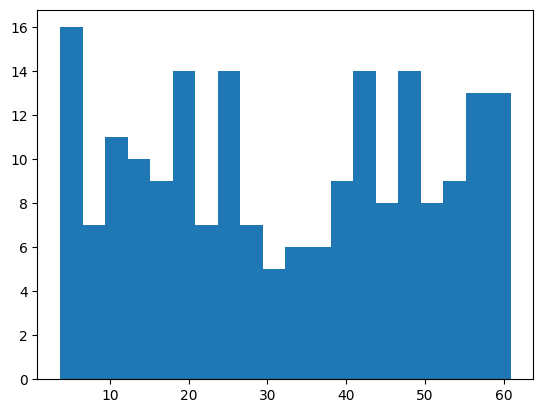

In [40]:
plt.hist(annualized_returns, bins=20)
plt.show()

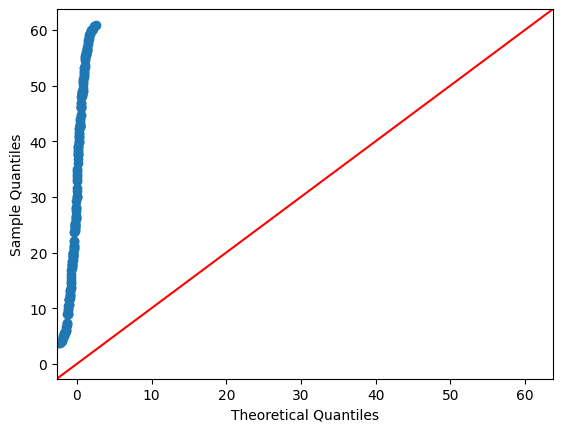

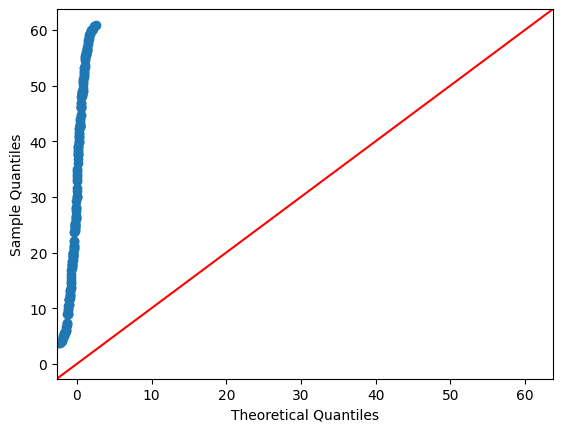

In [41]:
sm.qqplot(np.array(annualized_returns), line ='45')

((array([3.46573590e-03, 8.43263005e-03, 1.34784950e-02, 1.85499498e-02,
         2.36472554e-02, 2.87706768e-02, 3.39204828e-02, 3.90969467e-02,
         4.43003458e-02, 4.95309620e-02, 5.47890815e-02, 6.00749950e-02,
         6.53889979e-02, 7.07313904e-02, 7.61024774e-02, 8.15025688e-02,
         8.69319796e-02, 9.23910299e-02, 9.78800451e-02, 1.03399356e-01,
         1.08949299e-01, 1.14530215e-01, 1.20142454e-01, 1.25786367e-01,
         1.31462315e-01, 1.37170663e-01, 1.42911784e-01, 1.48686055e-01,
         1.54493863e-01, 1.60335598e-01, 1.66211659e-01, 1.72122454e-01,
         1.78068393e-01, 1.84049898e-01, 1.90067397e-01, 1.96121326e-01,
         2.02212127e-01, 2.08340255e-01, 2.14506168e-01, 2.20710335e-01,
         2.26953235e-01, 2.33235353e-01, 2.39557186e-01, 2.45919238e-01,
         2.52322026e-01, 2.58766074e-01, 2.65251917e-01, 2.71780101e-01,
         2.78351183e-01, 2.84965729e-01, 2.91624319e-01, 2.98327543e-01,
         3.05076004e-01, 3.11870316e-01, 3.18711107

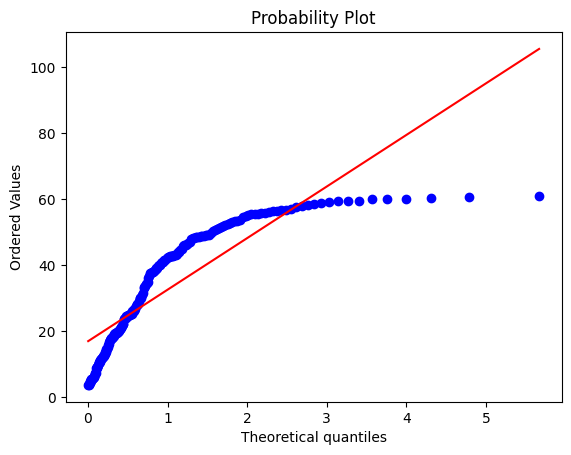

In [42]:
import scipy
scipy.stats.probplot(annualized_returns, dist="expon", plot=plt)